In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
plt.rc('font', family='NanumBarunGothic')
import gc
import os
import datetime
from tqdm import tqdm_notebook
import re
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = matplotlib.font_manager.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
matplotlib.font_manager._rebuild()
# 실행 후 런타임 재시작

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


# Data

In [ ]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/빅콘2020/train_preprocessing11.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/빅콘2020/test_preprocessing11.csv')
print('train shape :', train.shape)
train.head()

train shape : (38309, 43)


,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,주문량,일시,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,tv,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,판매단가bin,방송순서,실제노출
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,2019-01-01 06:00:00,1,1,6,0,1,1,3,1,1,train,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,3,1,10.0
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,109.548872,2019-01-01 06:00:00,1,1,6,0,1,1,3,1,1,train,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,3,1,10.0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,81.754386,2019-01-01 06:00:00,1,1,6,20,1,1,3,1,1,train,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,3,2,10.0
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,174.310777,2019-01-01 06:00:00,1,1,6,20,1,1,3,1,1,valid,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,3,2,10.0
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,167.218045,2019-01-01 06:00:00,1,1,6,40,1,1,3,1,1,valid,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,3,3,10.0


In [ ]:
print('test shape :', test.shape)
test.head()

test shape : (2891, 41)


,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,일시,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,판매단가bin,방송순서,실제노출
0,2020-06-01 06:20:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01 06:00:00,6,1,6,20,0,23,1,0,1,18.200000,17.8,1.514596,0.019048,0.0,0.040237,1.690476,1.5,1.121118,88.714286,93.0,10.335100,20.088889,23.0,8.827294,0.0,1.0,3.868,0.001240,0.004642,5,1,20.0
1,2020-06-01 06:40:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01 06:00:00,6,1,6,40,0,23,1,0,1,18.200000,17.8,1.514596,0.019048,0.0,0.040237,1.690476,1.5,1.121118,88.714286,93.0,10.335100,20.088889,23.0,8.827294,0.0,1.0,3.868,0.001240,0.004642,5,2,20.0
2,2020-06-01 07:00:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01 07:00:00,6,1,7,0,0,23,1,0,1,18.714286,18.6,1.514030,0.004762,0.0,0.021822,1.823810,1.5,1.279807,85.809524,87.0,10.342239,18.333333,19.0,10.535654,0.0,0.0,8.379,0.002686,0.009230,5,3,20.0
3,2020-06-01 07:20:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020-06-01 07:00:00,6,1,7,20,0,23,1,0,1,18.714286,18.6,1.514030,0.004762,0.0,0.021822,1.823810,1.5,1.279807,85.809524,87.0,10.342239,18.333333,19.0,10.535654,0.0,0.0,8.379,0.002686,0.009230,6,1,20.0
4,2020-06-01 07:40:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020-06-01 07:00:00,6,1,7,40,0,23,1,0,1,18.714286,18.6,1.514030,0.004762,0.0,0.021822,1.823810,1.5,1.279807,85.809524,87.0,10.342239,18.333333,19.0,10.535654,0.0,0.0,8.379,0.002686,0.009230,6,2,20.0


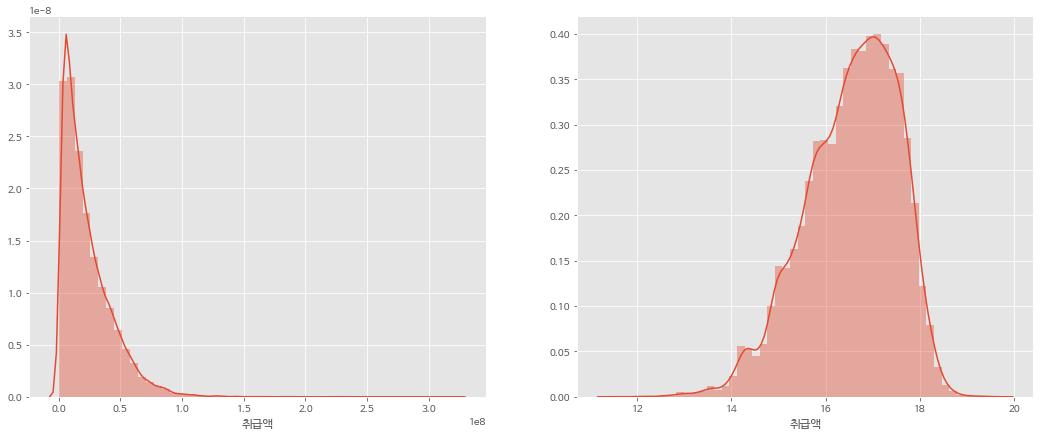

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
sns.distplot(train[train['취급액'].isna() != True]['취급액'], ax=ax[0])
sns.distplot(np.log(train[train['취급액'].isna() != True]['취급액']), ax=ax[1])

In [ ]:
def half(x):
  lx = len(x)
  return x[:int(lx/2)]

In [ ]:
train['상품명'].map(half)[:20]

0             테이트 남성
1             테이트 여성
2             테이트 남성
3             테이트 여성
4             테이트 남성
5             테이트 여성
6           오모떼 레이스 
7           오모떼 레이스 
8           오모떼 레이스 
9     CERINI by PAT 
10    CERINI by PAT 
11    CERINI by PAT 
12             보코 리버
13             보코 리버
14             보코 리버
15    CERINI by PAT 
16    CERINI by PAT 
17    CERINI by PAT 
18      크로커다일 The 편안
19      크로커다일 The 편안
Name: 상품명, dtype: object

In [ ]:
train['상품명'][0][:int(13/2)]

'테이트 남성'

In [ ]:
train['상품명'][29][:int(16/2)]

'뽕셰프 이봉원 '

In [ ]:
train['상품명'][29]

'뽕셰프 이봉원 특갈비탕 12팩'

# JensenShannon

In [ ]:
train_c = pd.read_csv('/content/drive/My Drive/Colab Notebooks/빅콘2020/train_c3.csv')
test_c = pd.read_csv('/content/drive/My Drive/Colab Notebooks/빅콘2020/test_c3.csv')
train_c.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,year,month,yearmonth,day,hour,new_name,clusters
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000,52.606516,2019,1,201901,1,6,ㅌㅔㅇㅣㅌㅡㄴㅏㅁㅅㅓㅇㅅㅔㄹㄹㅣㄴㄴㅣㅌㅡ3ㅈㅗㅇ,223
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000,109.548872,2019,1,201901,1,6,ㅌㅔㅇㅣㅌㅡㅇㅕㅅㅓㅇㅅㅔㄹㄹㅣㄴㄴㅣㅌㅡ3ㅈㅗㅇ,223
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000,81.754386,2019,1,201901,1,6,ㅌㅔㅇㅣㅌㅡㄴㅏㅁㅅㅓㅇㅅㅔㄹㄹㅣㄴㄴㅣㅌㅡ3ㅈㅗㅇ,223
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000,174.310777,2019,1,201901,1,6,ㅌㅔㅇㅣㅌㅡㅇㅕㅅㅓㅇㅅㅔㄹㄹㅣㄴㄴㅣㅌㅡ3ㅈㅗㅇ,223
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000,167.218045,2019,1,201901,1,6,ㅌㅔㅇㅣㅌㅡㄴㅏㅁㅅㅓㅇㅅㅔㄹㄹㅣㄴㄴㅣㅌㅡ3ㅈㅗㅇ,223


In [ ]:
test_c.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,year,month,yearmonth,day,hour,new_name,cluster_dict,cc,new_clusters
0,2020-06-01 06:20:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,0,0.0,2020,6,202006,1,6,ㅈㅐㄱㅍㅣㄹㄷㅡㄴㅏㅁㅅㅓㅇㅂㅏㄴㅍㅏㄹㅅㅕㅊㅡ4ㅈㅗㅇ,[55],55,55
1,2020-06-01 06:40:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,0,0.0,2020,6,202006,1,6,ㅈㅐㄱㅍㅣㄹㄷㅡㄴㅏㅁㅅㅓㅇㅂㅏㄴㅍㅏㄹㅅㅕㅊㅡ4ㅈㅗㅇ,[55],55,55
2,2020-06-01 07:00:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,0,0.0,2020,6,202006,1,7,ㅈㅐㄱㅍㅣㄹㄷㅡㄴㅏㅁㅅㅓㅇㅂㅏㄴㅍㅏㄹㅅㅕㅊㅡ4ㅈㅗㅇ,[55],55,55
3,2020-06-01 07:20:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,0,0.0,2020,6,202006,1,7,ㅋㅜㅁㅣㅌㅜㄴㅣㅋㅏㅋㅜㄹㄹㅔㅇㅣㅅㅣㄹㅏㄴㅈㅠㅅㅞㅇㅣㅍㅓ&ㅍㅐㄴㅌㅣ,[41],41,41
4,2020-06-01 07:40:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,0,0.0,2020,6,202006,1,7,ㅋㅜㅁㅣㅌㅜㄴㅣㅋㅏㅋㅜㄹㄹㅔㅇㅣㅅㅣㄹㅏㄴㅈㅠㅅㅞㅇㅣㅍㅓ&ㅍㅐㄴㅌㅣ,[41],41,41


In [ ]:
train_cc = pd.read_csv('/content/drive/My Drive/Colab Notebooks/빅콘2020/nc_train.csv')
test_cc = pd.read_csv('/content/drive/My Drive/Colab Notebooks/빅콘2020/nc_test.csv')
train_cc = train_cc[['상품명', 'name_c']].rename({'name_c':'중분류'}, axis='columns')
test_cc = test_cc[['상품명', 'name_c']].rename({'name_c':'중분류'}, axis='columns')
train_cc.head()

,상품명,중분류
0,테이트 남성 셀린니트3종,171
1,테이트 여성 셀린니트3종,172
2,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,170
3,보코 리버시블 무스탕,178
4,CERINI by PAT 남성 풀패키지 기모니트 3종,164


In [ ]:
def JensenShannon_similarity(df, time_list, st_list, cal_col):
  '''
  [함수 사용법]
    X축에 들어갈 변수를 input_list 인덱싱 0번 자리(맨앞)에 둘 것
    그 뒤로 기준을 잡고 싶은 변수들을 차례로 넣어 주면 됩니다.
    from scipy.spatial import distance 꼭 할것!
  '''

  make_amt= df.groupby(time_list+st_list)[cal_col].sum().reset_index()
  
  '''pivot 만들기'''
  amt_sum = make_amt.groupby(st_list)[cal_col].sum().reset_index(name='cal_col_sum')
  amt_sum = amt_sum[amt_sum['cal_col_sum'] != 0] #JSD를 구할때 0이 있으면 문제가 생김
  make_amt = make_amt.merge(amt_sum, on=st_list, how='left')
  make_amt['cal_col_prob'] = make_amt[cal_col] / make_amt['cal_col_sum']

  # pivot_table을 활용하여 long to wide 작업 실시
  amt_pivot = pd.pivot_table(make_amt,
                             index=st_list,
                             columns=time_list,
                             values='cal_col_prob').reset_index()
  amt_pivot.fillna(0, inplace=True)

  #피벗된 연도별 amt를 사용해 고객간의 유사도를 구해보자.
  amt_array=np.array(amt_pivot.drop(st_list, axis=1))

  js_similarity = []
  for row_r in range(amt_array.shape[0]):       
    dt_list = []
    for row_c in range(amt_array.shape[0]):
      #dt= js_divergence(amt_pivot.iloc[row_r, 3:].values,amt_pivot.iloc[row_c,3:].values)
      '''
      js_divergence(만든 함수)로 하면 0값을 계산을 못함. 
      sqrt(js_divergence)인 distance.jensenshannon 함수 사용
      '''
      dt = distance.jensenshannon(amt_array[row_r,:], amt_array[row_c,:],2.0)
      dt_list.append(dt)
    js_similarity.append(dt_list)

  js_frame =pd.DataFrame(np.array(js_similarity))
  js_similarity = pd.concat([amt_pivot, js_frame], axis=1)

  return amt_sum[st_list], js_similarity

In [ ]:
def make_clustering(gp_df, time_list, st_list, cal_col, cluster_name, split_num=2):
  st_series,df = JensenShannon_similarity(gp_df, time_list, st_list, cal_col)
  df_s = df.iloc[:, -df.shape[0]:] # 클러스터링용 dataframe 생성
  df_s.fillna(0, inplace=True)

  #클러스터링
  clustering = AgglomerativeClustering(n_clusters = int(df_s.shape[0] / split_num),
                                       affinity = 'precomputed',
                                       linkage = 'average')
  clustering.fit(df_s)
  
  return_df = pd.DataFrame(st_series)         #pd.DataFrame(DataFrame) 오류X

  print(return_df.shape, len(clustering.labels_))

  return_df[cluster_name] = clustering.labels_
  return return_df

In [ ]:
t_c = train_c[['방송일시', '상품코드', 'clusters']].rename({'clusters': '브랜드'}, axis='columns')
tt_c = test_c[['방송일시', '상품코드', 'new_clusters']].rename({'new_clusters': '브랜드'}, axis='columns')
t_c.head()

,방송일시,상품코드,브랜드
0,2019-01-01 06:00:00,201072,223
1,2019-01-01 06:00:00,201079,223
2,2019-01-01 06:20:00,201072,223
3,2019-01-01 06:20:00,201079,223
4,2019-01-01 06:40:00,201072,223


In [ ]:
tt_c.head()

,방송일시,상품코드,브랜드
0,2020-06-01 06:20:00,201971,55
1,2020-06-01 06:40:00,201971,55
2,2020-06-01 07:00:00,201971,55
3,2020-06-01 07:20:00,202278,41
4,2020-06-01 07:40:00,202278,41


In [ ]:
train = pd.merge(train, t_c, on=['방송일시', '상품코드'], how='left')
test = pd.merge(test, tt_c, on=['방송일시', '상품코드'], how='left')
train = pd.merge(train, train_cc, on='상품명', how='left')
test = pd.merge(test, test_cc, on='상품명', how='left')
train.head(1)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,주문량,일시,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,tv,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,판매단가bin,방송순서,실제노출,브랜드,중분류
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,2019-01-01 06:00:00,1,1,6,0,1,1,3,1,1,train,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,3,1,10.0,223,171.0


In [ ]:
test.head(1)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,일시,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,판매단가bin,방송순서,실제노출,브랜드,중분류
0,2020-06-01 06:20:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01 06:00:00,6,1,6,20,0,23,1,0,1,18.2,17.8,1.514596,0.019048,0.0,0.040237,1.690476,1.5,1.121118,88.714286,93.0,10.3351,20.088889,23.0,8.827294,0.0,1.0,3.868,0.00124,0.004642,5,1,20.0,55,175.0


In [ ]:
c1 = make_clustering(train, ['month'], ['브랜드'], '취급액', 'month_브랜드_취급액', split_num=2)
c2 = make_clustering(train, ['hour'], ['브랜드'], '취급액', 'hour_브랜드_취급액', split_num=2)
c3 = make_clustering(train, ['business_day'], ['브랜드'], '취급액', 'business_day_브랜드_취급액', split_num=2)
c4 = make_clustering(train, ['season'], ['브랜드'], '취급액', 'season_브랜드_취급액', split_num=2)
c5 = make_clustering(train, ['weekday'], ['브랜드'], '취급액', 'weekday_브랜드_취급액', split_num=2)
c6 = make_clustering(train, ['weekofyear'], ['브랜드'], '취급액', 'weekofyear_브랜드_취급액', split_num=2)
c7 = make_clustering(train, ['판매단가bin'], ['브랜드'], '취급액', '판매단가bin_브랜드_취급액', split_num=2)
c8 = make_clustering(train, ['방송순서'], ['브랜드'], '취급액', '방송순서_브랜드_취급액', split_num=2)
c9 = make_clustering(train, ['month'], ['브랜드'], '주문량', 'month_브랜드_주문량', split_num=2)
c10 = make_clustering(train, ['hour'], ['브랜드'], '주문량', 'hour_브랜드_주문량', split_num=2)
c11 = make_clustering(train, ['business_day'], ['브랜드'], '주문량', 'business_day_브랜드_주문량', split_num=2)
c12 = make_clustering(train, ['season'], ['브랜드'], '주문량', 'season_브랜드_주문량', split_num=2)
c13 = make_clustering(train, ['weekday'], ['브랜드'], '주문량', 'weekday_브랜드_주문량', split_num=2)
c14 = make_clustering(train, ['weekofyear'], ['브랜드'], '주문량', 'weekofyear_브랜드_주문량', split_num=2)
c15 = make_clustering(train, ['판매단가bin'], ['브랜드'], '주문량', '판매단가bin_브랜드_주문량', split_num=2)
c16 = make_clustering(train, ['방송순서'], ['브랜드'], '주문량', '방송순서_브랜드_주문량', split_num=2)
c9.head()

(546, 1) 546
(546, 1) 546
(546, 1) 546
(546, 1) 546
(546, 1) 546
(546, 1) 546
(546, 1) 546
(546, 1) 546
(546, 1) 546
(546, 1) 546
(546, 1) 546
(546, 1) 546
(546, 1) 546
(546, 1) 546
(546, 1) 546
(546, 1) 546


,브랜드,month_브랜드_주문량
0,0,51
1,1,248
2,2,232
3,3,192
4,4,155


In [ ]:
c17 = make_clustering(train, ['month'], ['중분류'], '취급액', 'month_중분류_취급액', split_num=2)
c18 = make_clustering(train, ['hour'], ['중분류'], '취급액', 'hour_중분류_취급액', split_num=2)
c19 = make_clustering(train, ['business_day'], ['중분류'], '취급액', 'business_day_중분류_취급액', split_num=2)
c20 = make_clustering(train, ['season'], ['중분류'], '취급액', 'season_중분류_취급액', split_num=2)
c21 = make_clustering(train, ['weekday'], ['중분류'], '취급액', 'weekday_중분류_취급액', split_num=2)
c22 = make_clustering(train, ['weekofyear'], ['중분류'], '취급액', 'weekofyear_중분류_취급액', split_num=2)
c23 = make_clustering(train, ['판매단가bin'], ['중분류'], '취급액', '판매단가bin_중분류_취급액', split_num=2)
c24 = make_clustering(train, ['방송순서'], ['중분류'], '취급액', '방송순서_중분류_취급액', split_num=2)
c25 = make_clustering(train, ['month'], ['중분류'], '주문량', 'month_중분류_주문량', split_num=2)
c26 = make_clustering(train, ['hour'], ['중분류'], '주문량', 'hour_중분류_주문량', split_num=2)
c27 = make_clustering(train, ['business_day'], ['중분류'], '주문량', 'business_day_중분류_주문량', split_num=2)
c28 = make_clustering(train, ['season'], ['중분류'], '주문량', 'season_중분류_주문량', split_num=2)
c29 = make_clustering(train, ['weekday'], ['중분류'], '주문량', 'weekday_중분류_주문량', split_num=2)
c30 = make_clustering(train, ['weekofyear'], ['중분류'], '주문량', 'weekofyear_중분류_주문량', split_num=2)
c31 = make_clustering(train, ['판매단가bin'], ['중분류'], '주문량', '판매단가bin_중분류_주문량', split_num=2)
c32 = make_clustering(train, ['방송순서'], ['중분류'], '주문량', '방송순서_중분류_주문량', split_num=2)
c17.head()

(269, 1) 269
(269, 1) 269
(269, 1) 269
(269, 1) 269
(269, 1) 269
(269, 1) 269
(269, 1) 269
(269, 1) 269
(269, 1) 269
(269, 1) 269
(269, 1) 269
(269, 1) 269
(269, 1) 269
(269, 1) 269
(269, 1) 269
(269, 1) 269


,중분류,month_중분류_취급액
0,0.0,68
1,1.0,12
2,2.0,5
3,3.0,84
4,4.0,5


In [ ]:
train.head(1)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,주문량,일시,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,tv,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,판매단가bin,방송순서,실제노출,브랜드,중분류
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,2019-01-01 06:00:00,1,1,6,0,1,1,3,1,1,train,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,3,1,10.0,223,171.0


In [ ]:
train['브랜드_mean'] = train.groupby('브랜드')['취급액'].transform('mean')
train['브랜드_median'] = train.groupby('브랜드')['취급액'].transform('median')
train['브랜드_std'] = train.groupby('브랜드')['취급액'].transform('std')
train['중분류_mean'] = train.groupby('중분류')['취급액'].transform('mean')
train['중분류_median'] = train.groupby('중분류')['취급액'].transform('median')
train['중분류_std'] = train.groupby('중분류')['취급액'].transform('std')
t1 = train[['브랜드', '브랜드_mean']].drop_duplicates()
t2 = train[['브랜드', '브랜드_median']].drop_duplicates()
t3 = train[['브랜드', '브랜드_std']].drop_duplicates()
t4 = train[['중분류', '중분류_mean']].drop_duplicates()
t5 = train[['중분류', '중분류_median']].drop_duplicates()
t6 = train[['중분류', '중분류_std']].drop_duplicates()
test = pd.merge(test, t1, on='브랜드', how='left')
test = pd.merge(test, t2, on='브랜드', how='left')
test = pd.merge(test, t3, on='브랜드', how='left')
test = pd.merge(test, t4, on='중분류', how='left')
test = pd.merge(test, t5, on='중분류', how='left')
test = pd.merge(test, t6, on='중분류', how='left')
train.head(1)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,주문량,일시,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,tv,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,판매단가bin,방송순서,실제노출,브랜드,중분류,브랜드_mean,브랜드_median,브랜드_std,중분류_mean,중분류_median,중분류_std
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,2019-01-01 06:00:00,1,1,6,0,1,1,3,1,1,train,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,3,1,10.0,223,171.0,7.252835e+06,6118000.0,4.524189e+06,1.630794e+07,13528000.0,1.035857e+07


In [ ]:
cl = [c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16]
cl2 = [c17, c18, c19, c20, c21, c22, c23, c24, c25, c26, c27, c28, c29, c30, c31, c32]
for c in cl:
  train = pd.merge(train, c, on='브랜드', how='left')
  test = pd.merge(test, c, on='브랜드', how='left')
for c in cl2:
  train = pd.merge(train, c, on='중분류', how='left')
  test = pd.merge(test, c, on='중분류', how='left')
train.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,주문량,일시,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,tv,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,...,브랜드,중분류,브랜드_mean,브랜드_median,브랜드_std,중분류_mean,중분류_median,중분류_std,month_브랜드_취급액,hour_브랜드_취급액,business_day_브랜드_취급액,season_브랜드_취급액,weekday_브랜드_취급액,weekofyear_브랜드_취급액,판매단가bin_브랜드_취급액,방송순서_브랜드_취급액,month_브랜드_주문량,hour_브랜드_주문량,business_day_브랜드_주문량,season_브랜드_주문량,weekday_브랜드_주문량,weekofyear_브랜드_주문량,판매단가bin_브랜드_주문량,방송순서_브랜드_주문량,month_중분류_취급액,hour_중분류_취급액,business_day_중분류_취급액,season_중분류_취급액,weekday_중분류_취급액,weekofyear_중분류_취급액,판매단가bin_중분류_취급액,방송순서_중분류_취급액,month_중분류_주문량,hour_중분류_주문량,business_day_중분류_주문량,season_중분류_주문량,weekday_중분류_주문량,weekofyear_중분류_주문량,판매단가bin_중분류_주문량,방송순서_중분류_주문량
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,2019-01-01 06:00:00,1,1,6,0,1,1,3,1,1,train,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,...,223,171.0,7.252835e+06,6118000.0,4.524189e+06,1.630794e+07,13528000.0,1.035857e+07,157.0,254.0,270.0,155.0,45.0,253.0,241.0,150.0,272.0,24.0,262.0,70.0,22.0,133.0,69.0,48.0,47.0,66.0,0.0,25.0,11.0,119.0,67.0,58.0,24.0,33.0,4.0,17.0,1.0,8.0,63.0,24.0
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,109.548872,2019-01-01 06:00:00,1,1,6,0,1,1,3,1,1,train,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,...,223,172.0,7.252835e+06,6118000.0,4.524189e+06,1.681992e+07,12058500.0,1.456405e+07,157.0,254.0,270.0,155.0,45.0,253.0,241.0,150.0,272.0,24.0,262.0,70.0,22.0,133.0,69.0,48.0,62.0,66.0,0.0,60.0,11.0,119.0,3.0,37.0,83.0,33.0,4.0,108.0,1.0,8.0,125.0,41.0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,81.754386,2019-01-01 06:00:00,1,1,6,20,1,1,3,1,1,train,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,...,223,171.0,7.252835e+06,6118000.0,4.524189e+06,1.630794e+07,13528000.0,1.035857e+07,157.0,254.0,270.0,155.0,45.0,253.0,241.0,150.0,272.0,24.0,262.0,70.0,22.0,133.0,69.0,48.0,47.0,66.0,0.0,25.0,11.0,119.0,67.0,58.0,24.0,33.0,4.0,17.0,1.0,8.0,63.0,24.0
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,174.310777,2019-01-01 06:00:00,1,1,6,20,1,1,3,1,1,valid,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,...,223,172.0,7.252835e+06,6118000.0,4.524189e+06,1.681992e+07,12058500.0,1.456405e+07,157.0,254.0,270.0,155.0,45.0,253.0,241.0,150.0,272.0,24.0,262.0,70.0,22.0,133.0,69.0,48.0,62.0,66.0,0.0,60.0,11.0,119.0,3.0,37.0,83.0,33.0,4.0,108.0,1.0,8.0,125.0,41.0
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,167.218045,2019-01-01 06:00:00,1,1,6,40,1,1,3,1,1,valid,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,...,223,171.0,7.252835e+06,6118000.0,4.524189e+06,1.630794e+07,13528000.0,1.035857e+07,157.0,254.0,270.0,155.0,45.0,253.0,241.0,150.0,272.0,24.0,262.0,70.0,22.0,133.0,69.0,48.0,47.0,66.0,0.0,25.0,11.0,119.0,67.0,58.0,24.0,33.0,4.0,17.0,1.0,8.0,63.0,24.0


In [ ]:
test.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,일시,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,판매단가bin,방송순서,...,브랜드,중분류,브랜드_mean,브랜드_median,브랜드_std,중분류_mean,중분류_median,중분류_std,month_브랜드_취급액,hour_브랜드_취급액,business_day_브랜드_취급액,season_브랜드_취급액,weekday_브랜드_취급액,weekofyear_브랜드_취급액,판매단가bin_브랜드_취급액,방송순서_브랜드_취급액,month_브랜드_주문량,hour_브랜드_주문량,business_day_브랜드_주문량,season_브랜드_주문량,weekday_브랜드_주문량,weekofyear_브랜드_주문량,판매단가bin_브랜드_주문량,방송순서_브랜드_주문량,month_중분류_취급액,hour_중분류_취급액,business_day_중분류_취급액,season_중분류_취급액,weekday_중분류_취급액,weekofyear_중분류_취급액,판매단가bin_중분류_취급액,방송순서_중분류_취급액,month_중분류_주문량,hour_중분류_주문량,business_day_중분류_주문량,season_중분류_주문량,weekday_중분류_주문량,weekofyear_중분류_주문량,판매단가bin_중분류_주문량,방송순서_중분류_주문량
0,2020-06-01 06:20:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01 06:00:00,6,1,6,20,0,23,1,0,1,18.200000,17.8,1.514596,0.019048,0.0,0.040237,1.690476,1.5,1.121118,88.714286,93.0,10.335100,20.088889,23.0,8.827294,0.0,1.0,3.868,0.001240,0.004642,5,1,...,55,175.0,4.165602e+07,37700000.0,2.340641e+07,1.977784e+07,16911000.0,1.139119e+07,248.0,7.0,1.0,198.0,17.0,200.0,256.0,32.0,261.0,10.0,13.0,163.0,212.0,236.0,248.0,32.0,32.0,133.0,14.0,21.0,130.0,5.0,31.0,10.0,113.0,1.0,4.0,2.0,1.0,40.0,26.0,62.0
1,2020-06-01 06:40:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01 06:00:00,6,1,6,40,0,23,1,0,1,18.200000,17.8,1.514596,0.019048,0.0,0.040237,1.690476,1.5,1.121118,88.714286,93.0,10.335100,20.088889,23.0,8.827294,0.0,1.0,3.868,0.001240,0.004642,5,2,...,55,175.0,4.165602e+07,37700000.0,2.340641e+07,1.977784e+07,16911000.0,1.139119e+07,248.0,7.0,1.0,198.0,17.0,200.0,256.0,32.0,261.0,10.0,13.0,163.0,212.0,236.0,248.0,32.0,32.0,133.0,14.0,21.0,130.0,5.0,31.0,10.0,113.0,1.0,4.0,2.0,1.0,40.0,26.0,62.0
2,2020-06-01 07:00:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01 07:00:00,6,1,7,0,0,23,1,0,1,18.714286,18.6,1.514030,0.004762,0.0,0.021822,1.823810,1.5,1.279807,85.809524,87.0,10.342239,18.333333,19.0,10.535654,0.0,0.0,8.379,0.002686,0.009230,5,3,...,55,175.0,4.165602e+07,37700000.0,2.340641e+07,1.977784e+07,16911000.0,1.139119e+07,248.0,7.0,1.0,198.0,17.0,200.0,256.0,32.0,261.0,10.0,13.0,163.0,212.0,236.0,248.0,32.0,32.0,133.0,14.0,21.0,130.0,5.0,31.0,10.0,113.0,1.0,4.0,2.0,1.0,40.0,26.0,62.0
3,2020-06-01 07:20:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020-06-01 07:00:00,6,1,7,20,0,23,1,0,1,18.714286,18.6,1.514030,0.004762,0.0,0.021822,1.823810,1.5,1.279807,85.809524,87.0,10.342239,18.333333,19.0,10.535654,0.0,0.0,8.379,0.002686,0.009230,6,1,...,41,160.0,4.191281e+07,37707500.0,2.109434e+07,2.484100e+07,25046000.0,1.466657e+07,267.0,32.0,56.0,152.0,30.0,147.0,231.0,63.0,236.0,6.0,53.0,162.0,7.0,227.0,236.0,14.0,101.0,51.0,42.0,36.0,82.0,3.0,9.0,109.0,40.0,110.0,52.0,20.0,20.0,57.0,2.0,60.0
4,2020-06-01 07:40:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020-06-01 07:00:00,6,1,7,40,0,23,1,0,1,18.714286,18.6,1.514030,0.004762,0.0,0.021822,1.823810,1.5,1.279807,85.809524,87.0,10.342239,18.333333,19.0,10.535654,0.0,0.0,8.379,0.002686,0.009230,6,2,...,41,160.0,4.191281e+07,37707500.0,2.109434e+07,2.484100e+07,25046000.0,1.466657e+07,267.0,32.0,56.0,152.0,30.0,147.0,231.0,63.0,236.0,6.0,53.0,162.0,7.0,227.0,236.0,14.0,101.0,51.0,42.0,36.0,82.0,3.0,9.0,109.0,40.0,110.0,52.0,20.0,20.0,57.0,2.0,60.0


In [ ]:
# train.to_csv('/content/drive/My Drive/Colab Notebooks/빅콘2020/train_preprocessing13.csv', index=False, encoding='utf-8-sig')
# test.to_csv('/content/drive/My Drive/Colab Notebooks/빅콘2020/test_preprocessing13.csv', index=False, encoding='utf-8-sig')

# 통계량까지 위에서 함 ㅋ

In [ ]:
train['train_test'] = 'train'
test['train_test'] = 'test'
tt = pd.concat((train, test), axis=0)
print(tt.shape)
tt.head()

(41200, 44)


,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,주문량,일시,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,tv,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,판매단가bin,방송순서,실제노출,train_test
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,2019-01-01 06:00:00,1,1,6,0,1,1,3,1,1,train,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,3,1,10.0,train
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,109.548872,2019-01-01 06:00:00,1,1,6,0,1,1,3,1,1,train,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,3,1,10.0,train
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,81.754386,2019-01-01 06:00:00,1,1,6,20,1,1,3,1,1,train,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,3,2,10.0,train
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,174.310777,2019-01-01 06:00:00,1,1,6,20,1,1,3,1,1,valid,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,3,2,10.0,train
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,167.218045,2019-01-01 06:00:00,1,1,6,40,1,1,3,1,1,valid,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,3,3,10.0,train


In [ ]:
tt.tail()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,주문량,일시,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,tv,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,판매단가bin,방송순서,실제노출,train_test
2886,2020-07-01 00:20:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN,NaN,2020-07-01 00:00:00,7,1,0,20,2,27,1,0,30,NaN,18.942857,18.8,1.121415,0.228571,0.0,0.400179,2.071429,1.8,1.499381,90.714286,92.0,7.177345,16.588889,14.0,11.313868,0.0,0.0,11.489,0.003613,0.014713,0,1,20.000000,test
2887,2020-07-01 00:40:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN,NaN,2020-07-01 00:00:00,7,1,0,40,2,27,1,0,30,NaN,18.942857,18.8,1.121415,0.228571,0.0,0.400179,2.071429,1.8,1.499381,90.714286,92.0,7.177345,16.588889,14.0,11.313868,0.0,0.0,11.489,0.003613,0.014713,0,2,20.000000,test
2888,2020-07-01 01:00:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN,NaN,2020-07-01 01:00:00,7,1,1,0,2,27,1,0,30,NaN,18.761905,18.7,1.146070,0.209524,0.0,0.361808,1.952381,1.9,1.327260,91.238095,92.0,6.722386,13.222222,12.0,6.402105,0.0,0.0,11.053,0.003476,0.009101,0,3,20.000000,test
2889,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,NaN,NaN,2020-07-01 01:00:00,7,1,1,20,2,27,1,0,30,NaN,18.761905,18.7,1.146070,0.209524,0.0,0.361808,1.952381,1.9,1.327260,91.238095,92.0,6.722386,13.222222,12.0,6.402105,0.0,1.0,11.053,0.003476,0.009101,6,1,20.000000,test
2890,2020-07-01 01:40:00,15.933333,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,NaN,NaN,2020-07-01 01:00:00,7,1,1,40,2,27,1,0,30,NaN,18.761905,18.7,1.146070,0.209524,0.0,0.361808,1.952381,1.9,1.327260,91.238095,92.0,6.722386,13.222222,12.0,6.402105,0.0,1.0,11.053,0.003476,0.009101,6,2,15.933333,test


# 여기

In [ ]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/빅콘2020/train_preprocessing13.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/빅콘2020/test_preprocessing13.csv')
train.head(1)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,주문량,일시,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,tv,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,...,브랜드,중분류,브랜드_mean,브랜드_median,브랜드_std,중분류_mean,중분류_median,중분류_std,month_브랜드_취급액,hour_브랜드_취급액,business_day_브랜드_취급액,season_브랜드_취급액,weekday_브랜드_취급액,weekofyear_브랜드_취급액,판매단가bin_브랜드_취급액,방송순서_브랜드_취급액,month_브랜드_주문량,hour_브랜드_주문량,business_day_브랜드_주문량,season_브랜드_주문량,weekday_브랜드_주문량,weekofyear_브랜드_주문량,판매단가bin_브랜드_주문량,방송순서_브랜드_주문량,month_중분류_취급액,hour_중분류_취급액,business_day_중분류_취급액,season_중분류_취급액,weekday_중분류_취급액,weekofyear_중분류_취급액,판매단가bin_중분류_취급액,방송순서_중분류_취급액,month_중분류_주문량,hour_중분류_주문량,business_day_중분류_주문량,season_중분류_주문량,weekday_중분류_주문량,weekofyear_중분류_주문량,판매단가bin_중분류_주문량,방송순서_중분류_주문량
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,2019-01-01 06:00:00,1,1,6,0,1,1,3,1,1,train,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,...,223,171.0,7.252835e+06,6118000.0,4.524189e+06,1.630794e+07,13528000.0,1.035857e+07,157.0,254.0,270.0,155.0,45.0,253.0,241.0,150.0,272.0,24.0,262.0,70.0,22.0,133.0,69.0,48.0,47.0,66.0,0.0,25.0,11.0,119.0,67.0,58.0,24.0,33.0,4.0,17.0,1.0,8.0,63.0,24.0


In [ ]:
ma = list(train['마더코드'].unique())
sa = list(train['상품코드'].unique())
for i in test.index:
  if test.loc[i, '상품코드'] not in sa:
    t = train[train['중분류'] == test.loc[i, '중분류']][['상품코드', '판매단가']].drop_duplicates()
    t['판'] = test.loc[i, '판매단가']
    t['판매'] = np.abs(t['판'] - t['판매단가'])
    if len(t) > 0:
      test.loc[i, '상품코드'] = t[t['판매'] == t['판매'].min()]['상품코드'].values[0]
  if test.loc[i, '마더코드'] not in ma:
    tt = train[train['브랜드'] == test.loc[i, '브랜드']][['마더코드', '판매단가']].drop_duplicates()
    tt['판'] = test.loc[i, '판매단가']
    tt['판매'] = np.abs(tt['판'] - tt['판매단가'])
    if len(tt) > 0:
      test.loc[i, '마더코드'] = tt[tt['판매'] == tt['판매'].min()]['마더코드'].values[0]
test.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,일시,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,판매단가bin,방송순서,...,브랜드,중분류,브랜드_mean,브랜드_median,브랜드_std,중분류_mean,중분류_median,중분류_std,month_브랜드_취급액,hour_브랜드_취급액,business_day_브랜드_취급액,season_브랜드_취급액,weekday_브랜드_취급액,weekofyear_브랜드_취급액,판매단가bin_브랜드_취급액,방송순서_브랜드_취급액,month_브랜드_주문량,hour_브랜드_주문량,business_day_브랜드_주문량,season_브랜드_주문량,weekday_브랜드_주문량,weekofyear_브랜드_주문량,판매단가bin_브랜드_주문량,방송순서_브랜드_주문량,month_중분류_취급액,hour_중분류_취급액,business_day_중분류_취급액,season_중분류_취급액,weekday_중분류_취급액,weekofyear_중분류_취급액,판매단가bin_중분류_취급액,방송순서_중분류_취급액,month_중분류_주문량,hour_중분류_주문량,business_day_중분류_주문량,season_중분류_주문량,weekday_중분류_주문량,weekofyear_중분류_주문량,판매단가bin_중분류_주문량,방송순서_중분류_주문량
0,2020-06-01 06:20:00,20.0,100714,201223,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01 06:00:00,6,1,6,20,0,23,1,0,1,18.200000,17.8,1.514596,0.019048,0.0,0.040237,1.690476,1.5,1.121118,88.714286,93.0,10.335100,20.088889,23.0,8.827294,0.0,1.0,3.868,0.001240,0.004642,5,1,...,55,175.0,4.165602e+07,37700000.0,2.340641e+07,1.977784e+07,16911000.0,1.139119e+07,248.0,7.0,1.0,198.0,17.0,200.0,256.0,32.0,261.0,10.0,13.0,163.0,212.0,236.0,248.0,32.0,32.0,133.0,14.0,21.0,130.0,5.0,31.0,10.0,113.0,1.0,4.0,2.0,1.0,40.0,26.0,62.0
1,2020-06-01 06:40:00,20.0,100714,201223,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01 06:00:00,6,1,6,40,0,23,1,0,1,18.200000,17.8,1.514596,0.019048,0.0,0.040237,1.690476,1.5,1.121118,88.714286,93.0,10.335100,20.088889,23.0,8.827294,0.0,1.0,3.868,0.001240,0.004642,5,2,...,55,175.0,4.165602e+07,37700000.0,2.340641e+07,1.977784e+07,16911000.0,1.139119e+07,248.0,7.0,1.0,198.0,17.0,200.0,256.0,32.0,261.0,10.0,13.0,163.0,212.0,236.0,248.0,32.0,32.0,133.0,14.0,21.0,130.0,5.0,31.0,10.0,113.0,1.0,4.0,2.0,1.0,40.0,26.0,62.0
2,2020-06-01 07:00:00,20.0,100714,201223,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020-06-01 07:00:00,6,1,7,0,0,23,1,0,1,18.714286,18.6,1.514030,0.004762,0.0,0.021822,1.823810,1.5,1.279807,85.809524,87.0,10.342239,18.333333,19.0,10.535654,0.0,0.0,8.379,0.002686,0.009230,5,3,...,55,175.0,4.165602e+07,37700000.0,2.340641e+07,1.977784e+07,16911000.0,1.139119e+07,248.0,7.0,1.0,198.0,17.0,200.0,256.0,32.0,261.0,10.0,13.0,163.0,212.0,236.0,248.0,32.0,32.0,133.0,14.0,21.0,130.0,5.0,31.0,10.0,113.0,1.0,4.0,2.0,1.0,40.0,26.0,62.0
3,2020-06-01 07:20:00,20.0,100445,202000,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020-06-01 07:00:00,6,1,7,20,0,23,1,0,1,18.714286,18.6,1.514030,0.004762,0.0,0.021822,1.823810,1.5,1.279807,85.809524,87.0,10.342239,18.333333,19.0,10.535654,0.0,0.0,8.379,0.002686,0.009230,6,1,...,41,160.0,4.191281e+07,37707500.0,2.109434e+07,2.484100e+07,25046000.0,1.466657e+07,267.0,32.0,56.0,152.0,30.0,147.0,231.0,63.0,236.0,6.0,53.0,162.0,7.0,227.0,236.0,14.0,101.0,51.0,42.0,36.0,82.0,3.0,9.0,109.0,40.0,110.0,52.0,20.0,20.0,57.0,2.0,60.0
4,2020-06-01 07:40:00,20.0,100445,202000,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020-06-01 07:00:00,6,1,7,40,0,23,1,0,1,18.714286,18.6,1.514030,0.004762,0.0,0.021822,1.823810,1.5,1.279807,85.809524,87.0,10.342239,18.333333,19.0,10.535654,0.0,0.0,8.379,0.002686,0.009230,6,2,...,41,160.0,4.191281e+07,37707500.0,2.109434e+07,2.484100e+07,25046000.0,1.466657e+07,267.0,32.0,56.0,152.0,30.0,147.0,231.0,63.0,236.0,6.0,53.0,162.0,7.0,227.0,236.0,14.0,101.0,51.0,42.0,36.0,82.0,3.0,9.0,109.0,40.0,110.0,52.0,20.0,20.0,57.0,2.0,60.0


In [ ]:
# train.to_csv('/content/drive/My Drive/Colab Notebooks/빅콘2020/train_preprocessing14.csv', index=False, encoding='utf-8-sig')
# test.to_csv('/content/drive/My Drive/Colab Notebooks/빅콘2020/test_preprocessing14.csv', index=False, encoding='utf-8-sig')

# Modeling

In [ ]:
def mape(y_true, y_pred):
  y_true = y_true.iloc[:, 0].values
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
train.head(1)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,주문량,일시,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,tv,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,...,브랜드,중분류,브랜드_mean,브랜드_median,브랜드_std,중분류_mean,중분류_median,중분류_std,month_브랜드_취급액,hour_브랜드_취급액,business_day_브랜드_취급액,season_브랜드_취급액,weekday_브랜드_취급액,weekofyear_브랜드_취급액,판매단가bin_브랜드_취급액,방송순서_브랜드_취급액,month_브랜드_주문량,hour_브랜드_주문량,business_day_브랜드_주문량,season_브랜드_주문량,weekday_브랜드_주문량,weekofyear_브랜드_주문량,판매단가bin_브랜드_주문량,방송순서_브랜드_주문량,month_중분류_취급액,hour_중분류_취급액,business_day_중분류_취급액,season_중분류_취급액,weekday_중분류_취급액,weekofyear_중분류_취급액,판매단가bin_중분류_취급액,방송순서_중분류_취급액,month_중분류_주문량,hour_중분류_주문량,business_day_중분류_주문량,season_중분류_주문량,weekday_중분류_주문량,weekofyear_중분류_주문량,판매단가bin_중분류_주문량,방송순서_중분류_주문량
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,2019-01-01 06:00:00,1,1,6,0,1,1,3,1,1,train,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,...,223,171.0,7.252835e+06,6118000.0,4.524189e+06,1.630794e+07,13528000.0,1.035857e+07,157.0,254.0,270.0,155.0,45.0,253.0,241.0,150.0,272.0,24.0,262.0,70.0,22.0,133.0,69.0,48.0,47.0,66.0,0.0,25.0,11.0,119.0,67.0,58.0,24.0,33.0,4.0,17.0,1.0,8.0,63.0,24.0


In [ ]:
trn_drop_cols = ['방송일시', '상품명', '취급액', '주문량', '일시', 'tv', '판매단가bin']
tes_drop_cols = ['방송일시', '상품명', '취급액', '일시', '판매단가bin']
x_train = train[(train['상품군'] != '무형') & (train['주문량'].isna() != True) & (train['tv'] == 'train')].drop(trn_drop_cols, axis=1)
y_train = np.log(train[(train['상품군'] != '무형') & (train['주문량'].isna() != True) & (train['tv'] == 'train')][['취급액']])
# y_train = train[(train['상품군'] != '무형') & (train['주문량'].isna() != True) & (train['tv'] == 'train')][['취급액']]
x_valid = train[(train['상품군'] != '무형') & (train['주문량'].isna() != True) & (train['tv'] == 'valid')].drop(trn_drop_cols, axis=1)
y_valid = train[(train['상품군'] != '무형') & (train['주문량'].isna() != True) & (train['tv'] == 'valid')][['취급액']]
# x_test = test.drop(tes_drop_cols, axis=1)
# real_y_train = train[(train['상품군'] != '무형') & (train['주문량'].isna() != True) & (train['tv'] == 'train')][['취급액']]
# real_y_valid = train[(train['상품군'] != '무형') & (train['주문량'].isna() != True) & (train['tv'] == 'valid')][['취급액']]
x_train.head()

,노출(분),마더코드,상품코드,상품군,판매단가,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,방송순서,실제노출,브랜드,중분류,브랜드_mean,브랜드_median,브랜드_std,중분류_mean,중분류_median,중분류_std,month_브랜드_취급액,hour_브랜드_취급액,business_day_브랜드_취급액,season_브랜드_취급액,weekday_브랜드_취급액,weekofyear_브랜드_취급액,판매단가bin_브랜드_취급액,방송순서_브랜드_취급액,month_브랜드_주문량,hour_브랜드_주문량,business_day_브랜드_주문량,season_브랜드_주문량,weekday_브랜드_주문량,weekofyear_브랜드_주문량,판매단가bin_브랜드_주문량,방송순서_브랜드_주문량,month_중분류_취급액,hour_중분류_취급액,business_day_중분류_취급액,season_중분류_취급액,weekday_중분류_취급액,weekofyear_중분류_취급액,판매단가bin_중분류_취급액,방송순서_중분류_취급액,month_중분류_주문량,hour_중분류_주문량,business_day_중분류_주문량,season_중분류_주문량,weekday_중분류_주문량,weekofyear_중분류_주문량,판매단가bin_중분류_주문량,방송순서_중분류_주문량
0,20.0,100346,201072,의류,39900,1,1,6,0,1,1,3,1,1,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,1,10.0,223,171.0,7.252835e+06,6118000.0,4.524189e+06,1.630794e+07,13528000.0,1.035857e+07,157.0,254.0,270.0,155.0,45.0,253.0,241.0,150.0,272.0,24.0,262.0,70.0,22.0,133.0,69.0,48.0,47.0,66.0,0.0,25.0,11.0,119.0,67.0,58.0,24.0,33.0,4.0,17.0,1.0,8.0,63.0,24.0
1,20.0,100346,201079,의류,39900,1,1,6,0,1,1,3,1,1,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,1,10.0,223,172.0,7.252835e+06,6118000.0,4.524189e+06,1.681992e+07,12058500.0,1.456405e+07,157.0,254.0,270.0,155.0,45.0,253.0,241.0,150.0,272.0,24.0,262.0,70.0,22.0,133.0,69.0,48.0,62.0,66.0,0.0,60.0,11.0,119.0,3.0,37.0,83.0,33.0,4.0,108.0,1.0,8.0,125.0,41.0
2,20.0,100346,201072,의류,39900,1,1,6,20,1,1,3,1,1,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,2,10.0,223,171.0,7.252835e+06,6118000.0,4.524189e+06,1.630794e+07,13528000.0,1.035857e+07,157.0,254.0,270.0,155.0,45.0,253.0,241.0,150.0,272.0,24.0,262.0,70.0,22.0,133.0,69.0,48.0,47.0,66.0,0.0,25.0,11.0,119.0,67.0,58.0,24.0,33.0,4.0,17.0,1.0,8.0,63.0,24.0
5,20.0,100346,201079,의류,39900,1,1,6,40,1,1,3,1,1,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,3,10.0,223,172.0,7.252835e+06,6118000.0,4.524189e+06,1.681992e+07,12058500.0,1.456405e+07,157.0,254.0,270.0,155.0,45.0,253.0,241.0,150.0,272.0,24.0,262.0,70.0,22.0,133.0,69.0,48.0,62.0,66.0,0.0,60.0,11.0,119.0,3.0,37.0,83.0,33.0,4.0,108.0,1.0,8.0,125.0,41.0
6,20.0,100305,200974,속옷,59000,1,1,7,0,1,1,3,1,1,-5.357143,-4.5,4.929865,0.0,0.0,0.0,1.680952,1.0,1.593932,64.666667,64.0,15.226074,36.555556,36.0,16.478100,0.0,0.0,6.516,0.002049,0.007027,1,20.0,89,148.0,3.116672e+07,24999000.0,1.823015e+07,3.336706e+07,29135500.0,2.138247e+07,86.0,209.0,191.0,270.0,55.0,232.0,249.0,86.0,259.0,190.0,267.0,28.0,131.0,138.0,21.0,90.0,123.0,5.0,0.0,133.0,1.0,6.0,55.0,102.0,3.0,13.0,4.0,107.0,2.0,2.0,82.0,22.0


In [ ]:
x_valid.head()

,노출(분),마더코드,상품코드,상품군,판매단가,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,방송순서,실제노출,브랜드,중분류,브랜드_mean,브랜드_median,브랜드_std,중분류_mean,중분류_median,중분류_std,month_브랜드_취급액,hour_브랜드_취급액,business_day_브랜드_취급액,season_브랜드_취급액,weekday_브랜드_취급액,weekofyear_브랜드_취급액,판매단가bin_브랜드_취급액,방송순서_브랜드_취급액,month_브랜드_주문량,hour_브랜드_주문량,business_day_브랜드_주문량,season_브랜드_주문량,weekday_브랜드_주문량,weekofyear_브랜드_주문량,판매단가bin_브랜드_주문량,방송순서_브랜드_주문량,month_중분류_취급액,hour_중분류_취급액,business_day_중분류_취급액,season_중분류_취급액,weekday_중분류_취급액,weekofyear_중분류_취급액,판매단가bin_중분류_취급액,방송순서_중분류_취급액,month_중분류_주문량,hour_중분류_주문량,business_day_중분류_주문량,season_중분류_주문량,weekday_중분류_주문량,weekofyear_중분류_주문량,판매단가bin_중분류_주문량,방송순서_중분류_주문량
3,20.0,100346,201079,의류,39900,1,1,6,20,1,1,3,1,1,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,2,10.0,223,172.0,7.252835e+06,6118000.0,4.524189e+06,1.681992e+07,12058500.0,1.456405e+07,157.0,254.0,270.0,155.0,45.0,253.0,241.0,150.0,272.0,24.0,262.0,70.0,22.0,133.0,69.0,48.0,62.0,66.0,0.0,60.0,11.0,119.0,3.0,37.0,83.0,33.0,4.0,108.0,1.0,8.0,125.0,41.0
4,20.0,100346,201072,의류,39900,1,1,6,40,1,1,3,1,1,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0.0,1.0,6.633,0.002086,0.006715,3,10.0,223,171.0,7.252835e+06,6118000.0,4.524189e+06,1.630794e+07,13528000.0,1.035857e+07,157.0,254.0,270.0,155.0,45.0,253.0,241.0,150.0,272.0,24.0,262.0,70.0,22.0,133.0,69.0,48.0,47.0,66.0,0.0,25.0,11.0,119.0,67.0,58.0,24.0,33.0,4.0,17.0,1.0,8.0,63.0,24.0
11,20.0,100808,202377,의류,59900,1,1,8,40,1,1,3,1,1,-5.409524,-5.0,4.994788,0.0,0.0,0.0,1.466667,0.6,1.701274,65.285714,63.0,15.317124,34.888889,34.0,18.058547,0.0,0.0,13.765,0.004329,0.010688,3,20.0,93,170.0,3.709945e+07,33845000.0,2.002090e+07,2.157794e+07,16882000.0,1.539234e+07,231.0,171.0,1.0,189.0,34.0,255.0,209.0,218.0,136.0,219.0,13.0,177.0,18.0,196.0,223.0,108.0,71.0,66.0,30.0,50.0,60.0,70.0,5.0,12.0,117.0,33.0,4.0,73.0,0.0,71.0,39.0,24.0
14,20.0,100816,202404,의류,79000,1,1,9,40,1,1,3,1,1,-4.123810,-2.5,4.633131,0.0,0.0,0.0,1.495238,0.9,1.465768,61.523810,62.0,13.396339,34.111111,27.0,19.681492,0.0,0.0,9.751,0.003066,0.009647,3,20.0,284,178.0,2.017647e+07,18277000.0,1.103849e+07,3.097171e+07,28436000.0,1.607034e+07,76.0,25.0,9.0,90.0,58.0,175.0,76.0,102.0,87.0,102.0,255.0,80.0,2.0,123.0,37.0,109.0,80.0,32.0,0.0,4.0,1.0,43.0,119.0,31.0,130.0,13.0,4.0,1.0,2.0,82.0,86.0,4.0
24,30.0,100305,200970,속옷,109000,1,1,13,30,1,1,3,1,1,0.871429,1.2,2.514387,0.0,0.0,0.0,3.233333,3.0,1.468105,47.619048,49.0,15.216689,25.333333,18.0,12.668859,1.0,0.0,14.708,0.004625,0.010699,2,30.0,411,149.0,4.131265e+07,33270500.0,2.003435e+07,2.394593e+07,17375000.0,2.131324e+07,67.0,241.0,237.0,72.0,135.0,8.0,33.0,134.0,0.0,244.0,242.0,38.0,29.0,8.0,42.0,128.0,20.0,5.0,0.0,16.0,1.0,6.0,77.0,1.0,16.0,13.0,4.0,87.0,2.0,4.0,81.0,58.0


In [ ]:
cat_fea = ['상품군', '마더코드', '상품코드', 'month', 'day', 'hour', 'minute', 'weekday', 'weekofyear', 'season', 'holiday', 'business_day', 'Primetime', 'Swingtime', '브랜드', 'month_브랜드_취급액', 'hour_브랜드_취급액', 'business_day_브랜드_취급액', 'season_브랜드_취급액', 'weekday_브랜드_취급액', 'weekofyear_브랜드_취급액', '판매단가bin_브랜드_취급액', '방송순서_브랜드_취급액', 'month_브랜드_주문량', 'hour_브랜드_주문량', 'business_day_브랜드_주문량', 'season_브랜드_주문량', 'weekday_브랜드_주문량', 'weekofyear_브랜드_주문량', '판매단가bin_브랜드_주문량', '방송순서_브랜드_주문량', 'month_중분류_취급액', 'hour_중분류_취급액', 'business_day_중분류_취급액', 'season_중분류_취급액', 'weekday_중분류_취급액', 'weekofyear_중분류_취급액', '판매단가bin_중분류_취급액', '방송순서_중분류_취급액', 'month_중분류_주문량', 'hour_중분류_주문량', 'business_day_중분류_주문량', 'season_중분류_주문량', 'weekday_중분류_주문량', 'weekofyear_중분류_주문량', '판매단가bin_중분류_주문량', '방송순서_중분류_주문량']

In [ ]:
l1 = ['Primetime', 'Swingtime', 'month_브랜드_취급액', 'hour_브랜드_취급액', 'business_day_브랜드_취급액', 'season_브랜드_취급액', 'weekday_브랜드_취급액', 'weekofyear_브랜드_취급액', '판매단가bin_브랜드_취급액', '방송순서_브랜드_취급액', 'month_브랜드_주문량', 'hour_브랜드_주문량', 'business_day_브랜드_주문량', 'season_브랜드_주문량', 'weekday_브랜드_주문량', 'weekofyear_브랜드_주문량', '판매단가bin_브랜드_주문량', '방송순서_브랜드_주문량', 'month_중분류_취급액', 'hour_중분류_취급액', 'business_day_중분류_취급액', 'season_중분류_취급액', 'weekday_중분류_취급액', 'weekofyear_중분류_취급액', '판매단가bin_중분류_취급액', '방송순서_중분류_취급액', 'month_중분류_주문량', 'hour_중분류_주문량', 'business_day_중분류_주문량', 'season_중분류_주문량', 'weekday_중분류_주문량', 'weekofyear_중분류_주문량', '판매단가bin_중분류_주문량', '방송순서_중분류_주문량']
for c in l1:
  x_train[c] = x_train[c].astype('int')
  x_valid[c] = x_valid[c].astype('int')
x_train.head(1)

,노출(분),마더코드,상품코드,상품군,판매단가,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,방송순서,실제노출,브랜드,중분류,브랜드_mean,브랜드_median,브랜드_std,중분류_mean,중분류_median,중분류_std,month_브랜드_취급액,hour_브랜드_취급액,business_day_브랜드_취급액,season_브랜드_취급액,weekday_브랜드_취급액,weekofyear_브랜드_취급액,판매단가bin_브랜드_취급액,방송순서_브랜드_취급액,month_브랜드_주문량,hour_브랜드_주문량,business_day_브랜드_주문량,season_브랜드_주문량,weekday_브랜드_주문량,weekofyear_브랜드_주문량,판매단가bin_브랜드_주문량,방송순서_브랜드_주문량,month_중분류_취급액,hour_중분류_취급액,business_day_중분류_취급액,season_중분류_취급액,weekday_중분류_취급액,weekofyear_중분류_취급액,판매단가bin_중분류_취급액,방송순서_중분류_취급액,month_중분류_주문량,hour_중분류_주문량,business_day_중분류_주문량,season_중분류_주문량,weekday_중분류_주문량,weekofyear_중분류_주문량,판매단가bin_중분류_주문량,방송순서_중분류_주문량
0,20.0,100346,201072,의류,39900,1,1,6,0,1,1,3,1,1,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0,1,6.633,0.002086,0.006715,1,10.0,223,171.0,7.252835e+06,6118000.0,4.524189e+06,1.630794e+07,13528000.0,1.035857e+07,157,254,270,155,45,253,241,150,272,24,262,70,22,133,69,48,47,66,0,25,11,119,67,58,24,33,4,17,1,8,63,24


In [ ]:
def a(x):
  d1 = {'의류': 1, '속옷': 2, '주방': 3, '농수축': 4, '이미용': 5, '가전': 6, '생활용품': 7,
          '건강기능': 8, '잡화': 9, '가구': 10, '침구': 11, '무형': 12}
  return d1[x]
x_train['상품군'] = x_train['상품군'].map(a)
x_valid['상품군'] = x_valid['상품군'].map(a)
# x_test['상품군'] = x_test['상품군'].map(a)
x_train.head(1)

,노출(분),마더코드,상품코드,상품군,판매단가,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,방송순서,실제노출,브랜드,중분류,브랜드_mean,브랜드_median,브랜드_std,중분류_mean,중분류_median,중분류_std,month_브랜드_취급액,hour_브랜드_취급액,business_day_브랜드_취급액,season_브랜드_취급액,weekday_브랜드_취급액,weekofyear_브랜드_취급액,판매단가bin_브랜드_취급액,방송순서_브랜드_취급액,month_브랜드_주문량,hour_브랜드_주문량,business_day_브랜드_주문량,season_브랜드_주문량,weekday_브랜드_주문량,weekofyear_브랜드_주문량,판매단가bin_브랜드_주문량,방송순서_브랜드_주문량,month_중분류_취급액,hour_중분류_취급액,business_day_중분류_취급액,season_중분류_취급액,weekday_중분류_취급액,weekofyear_중분류_취급액,판매단가bin_중분류_취급액,방송순서_중분류_취급액,month_중분류_주문량,hour_중분류_주문량,business_day_중분류_주문량,season_중분류_주문량,weekday_중분류_주문량,weekofyear_중분류_주문량,판매단가bin_중분류_주문량,방송순서_중분류_주문량
0,20.0,100346,201072,1,39900,1,1,6,0,1,1,3,1,1,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0,1,6.633,0.002086,0.006715,1,10.0,223,171.0,7.252835e+06,6118000.0,4.524189e+06,1.630794e+07,13528000.0,1.035857e+07,157,254,270,155,45,253,241,150,272,24,262,70,22,133,69,48,47,66,0,25,11,119,67,58,24,33,4,17,1,8,63,24


## LightGBM

In [ ]:
lgb_params = {'num_leaves':10,
              'learning_rate':0.05,
              'max_depth':6,
              'boosting':'gbdt',
              'objective':'regression',
              'metric':'mape',
              'lambda_l1':0.98,
              'lambda_l2':0.7,
              'min_data_in_leaf':1,
              'bagging_fraction':0.9,
              'feature_fraction':0.9,
              'feature_fraction_seed':42,
              'bagging_seed':42,
              'seed':42}

In [ ]:
# %%time

# n_ = 5
# kf = KFold(n_splits=n_, shuffle=True, random_state=42)
# lgb_pred = np.zeros(len(x_valid))

# for fold_, (trn_idx, val_idx) in enumerate(kf.split(x_train, y_train)):
#     print("fold num_: {}".format(fold_+1))
#     trn_data = lgb.Dataset(x_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
#     val_data = lgb.Dataset(x_train.iloc[val_idx], label=y_train.iloc[val_idx])

#     num_round = 10000
#     lgb_model = lgb.train(params = lgb_params,
#                           train_set = trn_data,
#                           num_boost_round = num_round,
#                           valid_sets = [trn_data, val_data],
#                           verbose_eval = 100,
#                           categorical_feature = cat_fea,
#                           early_stopping_rounds = 100)

#     lgb_pred += lgb_model.predict(x_valid, num_iteration=lgb_model.best_iteration) / n_
    
# print('\nCross Validation Is Complete')

fold num_: 1
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0200522	valid_1's mape: 0.0216956
[200]	training's mape: 0.018178	valid_1's mape: 0.0205271
[300]	training's mape: 0.0172536	valid_1's mape: 0.0200703
[400]	training's mape: 0.0165962	valid_1's mape: 0.0198712
[500]	training's mape: 0.0160961	valid_1's mape: 0.0197009
[600]	training's mape: 0.0156874	valid_1's mape: 0.019557
[700]	training's mape: 0.0153486	valid_1's mape: 0.0194524
[800]	training's mape: 0.0150289	valid_1's mape: 0.019364
[900]	training's mape: 0.01473	valid_1's mape: 0.0192874
[1000]	training's mape: 0.0144608	valid_1's mape: 0.0191933
[1100]	training's mape: 0.0142044	valid_1's mape: 0.0191301
[1200]	training's mape: 0.0139601	valid_1's mape: 0.0190663
[1300]	training's mape: 0.0137456	valid_1's mape: 0.0190143
[1400]	training's mape: 0.0135398	valid_1's mape: 0.0189755
[1500]	training's mape: 0.0133489	valid_1's mape: 0.0189429
[1600]	training's mape: 0.0131616	vali

In [ ]:
lgb_pred[:20]

array([15.39556753, 15.68708366, 17.6823663 , 17.36831958, 18.04921577,
       16.79145371, 16.79145371, 16.56692458, 17.75353103, 17.41632262,
       18.11205596, 17.91770422, 17.60727543, 18.16273743, 16.17955849,
       16.55005239, 16.31976984, 17.10263113, 17.4354218 , 16.18521437])

In [ ]:
lgb_pred[:20]

array([15.46095599, 15.71368183, 17.69522721, 17.35248895, 18.00525696,
       16.75280886, 16.75280886, 16.66216707, 17.71334997, 17.42382304,
       18.11789758, 17.89311231, 17.58047311, 18.13283399, 16.16309559,
       16.52481227, 16.24409749, 17.09916471, 17.36138612, 16.21167171])

In [ ]:
lgb_pred = np.exp(lgb_pred)
lgb_pred = lgb_pred.round(-3)
lgb_pred[:20]

array([ 5183000.,  6674000., 48410000., 34363000., 66006000., 18865000.,
       18865000., 17230000., 49296000., 36904000., 73876000., 59004000.,
       43162000., 74988000., 10460000., 15019000., 11343000., 26673000.,
       34670000., 10981000.])

In [ ]:
mape(y_valid, lgb_pred)

31.65147833846296

## Stratified

In [ ]:
%%time

n_ = 10
skf = StratifiedKFold(n_splits=n_, shuffle=True, random_state=42)
lgb_pred = np.zeros(len(x_valid))

for fold_, (trn_idx, val_idx) in enumerate(skf.split(x_train, x_train['상품군'])):
    print("fold num_: {}".format(fold_+1))
    trn_data = lgb.Dataset(x_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(x_train.iloc[val_idx], label=y_train.iloc[val_idx])

    num_round = 10000
    lgb_model = lgb.train(params = lgb_params,
                          train_set = trn_data,
                          num_boost_round = num_round,
                          valid_sets = [trn_data, val_data],
                          verbose_eval = 100,
                          categorical_feature = cat_fea,
                          early_stopping_rounds = 100)

    lgb_pred += lgb_model.predict(x_valid, num_iteration=lgb_model.best_iteration) / n_
    
print('\nCross Validation Is Complete')

fold num_: 1
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.0200386	valid_1's mape: 0.0212212
[200]	training's mape: 0.0181194	valid_1's mape: 0.0199313
[300]	training's mape: 0.0172053	valid_1's mape: 0.0194384
[400]	training's mape: 0.0165555	valid_1's mape: 0.0191512
[500]	training's mape: 0.016006	valid_1's mape: 0.0189347
[600]	training's mape: 0.0155646	valid_1's mape: 0.0187727
[700]	training's mape: 0.0152148	valid_1's mape: 0.0186589
[800]	training's mape: 0.0148932	valid_1's mape: 0.0185668
[900]	training's mape: 0.014586	valid_1's mape: 0.0184738
[1000]	training's mape: 0.0143272	valid_1's mape: 0.0183912
[1100]	training's mape: 0.0140891	valid_1's mape: 0.018323
[1200]	training's mape: 0.0138671	valid_1's mape: 0.0182712
[1300]	training's mape: 0.0136469	valid_1's mape: 0.0182174
[1400]	training's mape: 0.0134499	valid_1's mape: 0.0181769
[1500]	training's mape: 0.0132817	valid_1's mape: 0.0181486
[1600]	training's mape: 0.0131138	va

In [ ]:
lgb_pred[:20]

array([15.5411186 , 15.59031258, 17.67311741, 17.3399853 , 18.05451569,
       16.83258669, 16.83258669, 16.69129805, 17.77193546, 17.39559483,
       18.09023412, 17.92048568, 17.59896938, 18.14343627, 16.0802319 ,
       16.47974497, 16.24071536, 17.07956076, 17.42571698, 16.21442609])

In [ ]:
lgb_pred = np.exp(lgb_pred)
lgb_pred = lgb_pred.round(-3)
lgb_pred[:20]

array([ 5616000.,  5899000., 47352000., 33936000., 69339000., 20431000.,
       20431000., 17739000., 52270000., 35877000., 71860000., 60641000.,
       43968000., 75787000.,  9628000., 14357000., 11305000., 26155000.,
       36974000., 11011000.])

In [ ]:
mape(y_valid, lgb_pred)

31.427064152550134

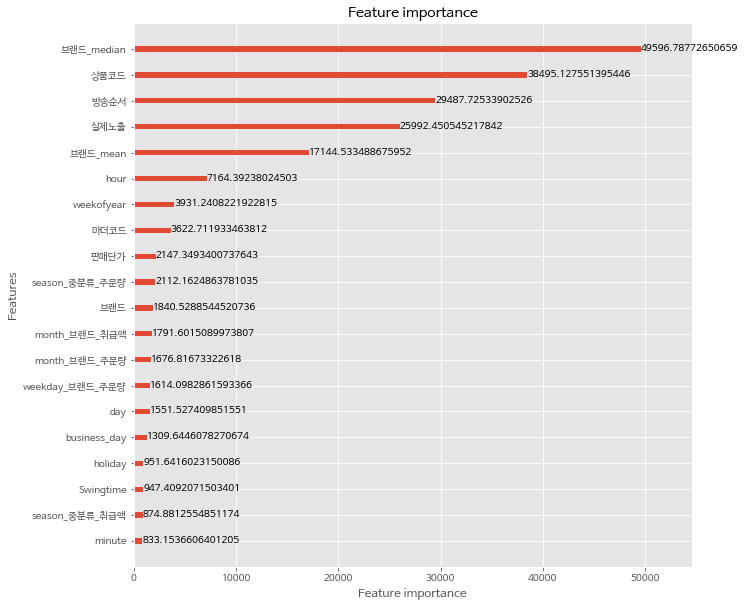

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
lgb.plot_importance(lgb_model, ax=ax, max_num_features=20, importance_type='gain')

# Catboost

In [ ]:
# for c in cat_fea:
#   x_train[c] = x_train[c].astype('object')
#   x_valid[c] = x_valid[c].astype('object')
# x_train['상품군'].dtype

dtype('O')

In [ ]:
%%time

model = CatBoostRegressor(loss_function = "MAPE",
                          eval_metric = "MAPE",
                          # task_type = "GPU",
                          # depth = 6,
                          learning_rate = 0.05,
                          iterations = 10000,
                          boosting_type = 'Plain', # 메모리 과부하 방지
                          # max_ctr_complexity = 4,
                          # gpu_cat_features_storage = 'CpuPinnedMemory',
                          early_stopping_rounds = 50)

n_ = 5
skf = StratifiedKFold(n_splits=n_, shuffle=True, random_state=42)
cat_pred = np.zeros(len(x_valid))

for fold_, (trn_idx, val_idx) in enumerate(skf.split(x_train, x_train['상품군'])):
  trn_data = x_train.iloc[trn_idx]
  trn_label = y_train.iloc[trn_idx]
  val_data = x_train.iloc[val_idx]
  val_label = y_train.iloc[val_idx]
  print("fold num_: {}".format(fold_+1))
  fit_model = model.fit(X = trn_data,
                        y = trn_label,
                        eval_set = (val_data, val_label),
                        cat_features = cat_fea,
                        use_best_model = True,
                        verbose = 100)
  cat_pred += fit_model.predict(x_valid) / 5

fold num_: 1
0:	learn: 0.0480130	test: 0.0479137	best: 0.0479137 (0)	total: 260ms	remaining: 43m 23s
100:	learn: 0.0228489	test: 0.0220072	best: 0.0220072 (100)	total: 17.1s	remaining: 28m
200:	learn: 0.0214152	test: 0.0208856	best: 0.0208856 (200)	total: 34.9s	remaining: 28m 20s
300:	learn: 0.0204371	test: 0.0202551	best: 0.0202551 (300)	total: 52.3s	remaining: 28m 4s
400:	learn: 0.0198379	test: 0.0199848	best: 0.0199848 (400)	total: 1m 9s	remaining: 27m 47s
500:	learn: 0.0193268	test: 0.0197574	best: 0.0197574 (500)	total: 1m 27s	remaining: 27m 36s
600:	learn: 0.0189124	test: 0.0195972	best: 0.0195972 (600)	total: 1m 45s	remaining: 27m 23s
700:	learn: 0.0185840	test: 0.0195042	best: 0.0195042 (700)	total: 2m 2s	remaining: 27m 10s
800:	learn: 0.0183005	test: 0.0194226	best: 0.0194226 (799)	total: 2m 20s	remaining: 26m 57s
900:	learn: 0.0180251	test: 0.0193374	best: 0.0193374 (900)	total: 2m 38s	remaining: 26m 42s
1000:	learn: 0.0177736	test: 0.0192660	best: 0.0192660 (1000)	total: 2m 

In [ ]:
cat_pred[:20]

array([15.81828108, 15.6396796 , 17.74037585, 17.44084647, 18.13350199,
       16.82222858, 16.83512488, 16.90019127, 17.69707345, 17.45256931,
       18.07290982, 17.87379489, 17.40192195, 18.14224279, 16.14186281,
       16.5990406 , 16.10505858, 17.18373429, 17.27033494, 16.17944619])

In [ ]:
cat_pred = np.exp(cat_pred)
cat_pred = cat_pred.round(-3)
cat_pred[:20]

array([ 7410000.,  6198000., 50646000., 37537000., 75038000., 20221000.,
       20483000., 21860000., 48500000., 37980000., 70626000., 57875000.,
       36104000., 75697000., 10241000., 16176000.,  9870000., 29027000.,
       31653000., 10633000.])

In [ ]:
mape(y_valid, cat_pred)

33.23452410707185

## test

In [ ]:
trn_drop_cols = ['방송일시', '상품명', '취급액', '주문량', '일시', 'tv', '판매단가bin']
tes_drop_cols = ['방송일시', '상품명', '취급액', '일시', '판매단가bin']
x_train = train[(train['상품군'] != '무형') & (train['주문량'].isna() != True)].drop(trn_drop_cols, axis=1)
y_train = np.log(train[(train['상품군'] != '무형') & (train['주문량'].isna() != True)][['취급액']])
x_test = test.drop(tes_drop_cols, axis=1)

In [ ]:
cat_fea = ['상품군', '마더코드', '상품코드', 'month', 'day', 'hour', 'minute', 'weekday', 'weekofyear', 'season', 'holiday', 'business_day', 'Primetime', 'Swingtime', '브랜드', 'month_브랜드_취급액', 'hour_브랜드_취급액', 'business_day_브랜드_취급액', 'season_브랜드_취급액', 'weekday_브랜드_취급액', 'weekofyear_브랜드_취급액', '판매단가bin_브랜드_취급액', '방송순서_브랜드_취급액', 'month_브랜드_주문량', 'hour_브랜드_주문량', 'business_day_브랜드_주문량', 'season_브랜드_주문량', 'weekday_브랜드_주문량', 'weekofyear_브랜드_주문량', '판매단가bin_브랜드_주문량', '방송순서_브랜드_주문량', 'month_중분류_취급액', 'hour_중분류_취급액', 'business_day_중분류_취급액', 'season_중분류_취급액', 'weekday_중분류_취급액', 'weekofyear_중분류_취급액', '판매단가bin_중분류_취급액', '방송순서_중분류_취급액', 'month_중분류_주문량', 'hour_중분류_주문량', 'business_day_중분류_주문량', 'season_중분류_주문량', 'weekday_중분류_주문량', 'weekofyear_중분류_주문량', '판매단가bin_중분류_주문량', '방송순서_중분류_주문량']

In [ ]:
l1 = ['Primetime', 'Swingtime', 'month_브랜드_취급액', 'hour_브랜드_취급액', 'business_day_브랜드_취급액', 'season_브랜드_취급액', 'weekday_브랜드_취급액', 'weekofyear_브랜드_취급액', '판매단가bin_브랜드_취급액', '방송순서_브랜드_취급액', 'month_브랜드_주문량', 'hour_브랜드_주문량', 'business_day_브랜드_주문량', 'season_브랜드_주문량', 'weekday_브랜드_주문량', 'weekofyear_브랜드_주문량', '판매단가bin_브랜드_주문량', '방송순서_브랜드_주문량', 'month_중분류_취급액', 'hour_중분류_취급액', 'business_day_중분류_취급액', 'season_중분류_취급액', 'weekday_중분류_취급액', 'weekofyear_중분류_취급액', '판매단가bin_중분류_취급액', '방송순서_중분류_취급액', 'month_중분류_주문량', 'hour_중분류_주문량', 'business_day_중분류_주문량', 'season_중분류_주문량', 'weekday_중분류_주문량', 'weekofyear_중분류_주문량', '판매단가bin_중분류_주문량', '방송순서_중분류_주문량']
for c in l1:
  x_train[c] = x_train[c].astype('int')
  x_valid[c] = x_valid[c].astype('int')
x_train.head(1)

,노출(분),마더코드,상품코드,상품군,판매단가,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,방송순서,실제노출,브랜드,중분류,브랜드_mean,브랜드_median,브랜드_std,중분류_mean,중분류_median,중분류_std,month_브랜드_취급액,hour_브랜드_취급액,business_day_브랜드_취급액,season_브랜드_취급액,weekday_브랜드_취급액,weekofyear_브랜드_취급액,판매단가bin_브랜드_취급액,방송순서_브랜드_취급액,month_브랜드_주문량,hour_브랜드_주문량,business_day_브랜드_주문량,season_브랜드_주문량,weekday_브랜드_주문량,weekofyear_브랜드_주문량,판매단가bin_브랜드_주문량,방송순서_브랜드_주문량,month_중분류_취급액,hour_중분류_취급액,business_day_중분류_취급액,season_중분류_취급액,weekday_중분류_취급액,weekofyear_중분류_취급액,판매단가bin_중분류_취급액,방송순서_중분류_취급액,month_중분류_주문량,hour_중분류_주문량,business_day_중분류_주문량,season_중분류_주문량,weekday_중분류_주문량,weekofyear_중분류_주문량,판매단가bin_중분류_주문량,방송순서_중분류_주문량
0,20.0,100346,201072,의류,39900,1,1,6,0,1,1,3,1,1,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0,1,6.633,0.002086,0.006715,1,10.0,223,171.0,7.252835e+06,6118000.0,4.524189e+06,1.630794e+07,13528000.0,1.035857e+07,157,254,270,155,45,253,241,150,272,24,262,70,22,133,69,48,47,66,0,25,11,119,67,58,24,33,4,17,1,8,63,24


In [ ]:
def a(x):
  d1 = {'의류': 1, '속옷': 2, '주방': 3, '농수축': 4, '이미용': 5, '가전': 6, '생활용품': 7,
          '건강기능': 8, '잡화': 9, '가구': 10, '침구': 11, '무형': 12}
  return d1[x]
x_train['상품군'] = x_train['상품군'].map(a)
x_test['상품군'] = x_test['상품군'].map(a)
x_train.head(1)

,노출(분),마더코드,상품코드,상품군,판매단가,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,방송순서,실제노출,브랜드,중분류,브랜드_mean,브랜드_median,브랜드_std,중분류_mean,중분류_median,중분류_std,month_브랜드_취급액,hour_브랜드_취급액,business_day_브랜드_취급액,season_브랜드_취급액,weekday_브랜드_취급액,weekofyear_브랜드_취급액,판매단가bin_브랜드_취급액,방송순서_브랜드_취급액,month_브랜드_주문량,hour_브랜드_주문량,business_day_브랜드_주문량,season_브랜드_주문량,weekday_브랜드_주문량,weekofyear_브랜드_주문량,판매단가bin_브랜드_주문량,방송순서_브랜드_주문량,month_중분류_취급액,hour_중분류_취급액,business_day_중분류_취급액,season_중분류_취급액,weekday_중분류_취급액,weekofyear_중분류_취급액,판매단가bin_중분류_취급액,방송순서_중분류_취급액,month_중분류_주문량,hour_중분류_주문량,business_day_중분류_주문량,season_중분류_주문량,weekday_중분류_주문량,weekofyear_중분류_주문량,판매단가bin_중분류_주문량,방송순서_중분류_주문량
0,20.0,100346,201072,1,39900,1,1,6,0,1,1,3,1,1,-5.309524,-4.2,4.773668,0.0,0.0,0.0,1.566667,1.0,1.554778,63.380952,62.0,15.078051,37.888889,34.0,16.594008,0,1,6.633,0.002086,0.006715,1,10.0,223,171.0,7.252835e+06,6118000.0,4.524189e+06,1.630794e+07,13528000.0,1.035857e+07,157,254,270,155,45,253,241,150,272,24,262,70,22,133,69,48,47,66,0,25,11,119,67,58,24,33,4,17,1,8,63,24


In [ ]:
x_test.head(1)

,노출(분),마더코드,상품코드,상품군,판매단가,month,day,hour,minute,weekday,weekofyear,season,holiday,business_day,temp_mean,temp_median,temp_std,rain_mean,rain_median,rain_std,wind_mean,wind_median,wind_std,wet_mean,wet_median,wet_std,mis_mean,mis_median,mis_std,Primetime,Swingtime,view_sum,view_mean,view_std,방송순서,실제노출,브랜드,중분류,브랜드_mean,브랜드_median,브랜드_std,중분류_mean,중분류_median,중분류_std,month_브랜드_취급액,hour_브랜드_취급액,business_day_브랜드_취급액,season_브랜드_취급액,weekday_브랜드_취급액,weekofyear_브랜드_취급액,판매단가bin_브랜드_취급액,방송순서_브랜드_취급액,month_브랜드_주문량,hour_브랜드_주문량,business_day_브랜드_주문량,season_브랜드_주문량,weekday_브랜드_주문량,weekofyear_브랜드_주문량,판매단가bin_브랜드_주문량,방송순서_브랜드_주문량,month_중분류_취급액,hour_중분류_취급액,business_day_중분류_취급액,season_중분류_취급액,weekday_중분류_취급액,weekofyear_중분류_취급액,판매단가bin_중분류_취급액,방송순서_중분류_취급액,month_중분류_주문량,hour_중분류_주문량,business_day_중분류_주문량,season_중분류_주문량,weekday_중분류_주문량,weekofyear_중분류_주문량,판매단가bin_중분류_주문량,방송순서_중분류_주문량
0,20.0,100714,201223,1,59800,6,1,6,20,0,23,1,0,1,18.2,17.8,1.514596,0.019048,0.0,0.040237,1.690476,1.5,1.121118,88.714286,93.0,10.3351,20.088889,23.0,8.827294,0.0,1.0,3.868,0.00124,0.004642,1,20.0,55,175.0,4.165602e+07,37700000.0,2.340641e+07,1.977784e+07,16911000.0,1.139119e+07,248.0,7.0,1.0,198.0,17.0,200.0,256.0,32.0,261.0,10.0,13.0,163.0,212.0,236.0,248.0,32.0,32.0,133.0,14.0,21.0,130.0,5.0,31.0,10.0,113.0,1.0,4.0,2.0,1.0,40.0,26.0,62.0


In [ ]:
lgb_params = {'num_leaves':10,
              'learning_rate':0.05,
              'max_depth':6,
              'boosting':'gbdt',
              'objective':'regression',
              'metric':'mape',
              'lambda_l1':0.98,
              'lambda_l2':0.7,
              'min_data_in_leaf':1,
              'bagging_fraction':0.9,
              'feature_fraction':0.9,
              'feature_fraction_seed':42,
              'bagging_seed':42,
              'seed':42}

In [ ]:
%%time

n_ = 10
skf = StratifiedKFold(n_splits=n_, shuffle=True, random_state=42)
lgb_pred = np.zeros(len(x_test))

for fold_, (trn_idx, val_idx) in enumerate(skf.split(x_train, x_train['상품군'])):
    print("fold num_: {}".format(fold_+1))
    trn_data = lgb.Dataset(x_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(x_train.iloc[val_idx], label=y_train.iloc[val_idx])

    num_round = 10000
    lgb_model = lgb.train(params = lgb_params,
                          train_set = trn_data,
                          num_boost_round = num_round,
                          valid_sets = [trn_data, val_data],
                          verbose_eval = 100,
                          categorical_feature = cat_fea,
                          early_stopping_rounds = 100)

    lgb_pred += lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration) / n_
    
print('\nCross Validation Is Complete')

fold num_: 1
Training until validation scores don't improve for 100 rounds.
[100]	training's mape: 0.019563	valid_1's mape: 0.020566
[200]	training's mape: 0.0176717	valid_1's mape: 0.0192409
[300]	training's mape: 0.0167931	valid_1's mape: 0.0186948
[400]	training's mape: 0.0161956	valid_1's mape: 0.0183591
[500]	training's mape: 0.0157317	valid_1's mape: 0.0181445
[600]	training's mape: 0.0153176	valid_1's mape: 0.0179833
[700]	training's mape: 0.014997	valid_1's mape: 0.0178374
[800]	training's mape: 0.0146999	valid_1's mape: 0.0177253
[900]	training's mape: 0.0144639	valid_1's mape: 0.0176265
[1000]	training's mape: 0.0142371	valid_1's mape: 0.0175422
[1100]	training's mape: 0.0140332	valid_1's mape: 0.0174637
[1200]	training's mape: 0.0138256	valid_1's mape: 0.0173986
[1300]	training's mape: 0.0136567	valid_1's mape: 0.0173519
[1400]	training's mape: 0.0135065	valid_1's mape: 0.0173042
[1500]	training's mape: 0.0133541	valid_1's mape: 0.0172566
[1600]	training's mape: 0.0132099	va

In [ ]:
lgb_pred[:20]

array([16.10461702, 16.56673862, 17.14917576, 16.60566947, 17.16672498,
       17.48027819, 16.46226404, 17.17188553, 17.34577711, 16.99982342,
       17.63769855, 17.76542505, 16.90281768, 17.47529194, 17.44265608,
       17.20568448, 17.61207187, 17.56861796, 16.82074971, 17.39894924])

In [ ]:
lgb_pred = np.exp(lgb_pred)
lgb_pred = lgb_pred.round(-3)
lgb_pred[:20]

array([ 9866000., 15662000., 28041000., 16284000., 28537000., 39047000.,
       14108000., 28685000., 34133000., 24151000., 45704000., 51931000.,
       21918000., 38853000., 37605000., 29671000., 44548000., 42653000.,
       20191000., 35997000.])

In [ ]:
submission = pd.read_excel('/content/drive/My Drive/Colab Notebooks/빅콘2020/02_평가데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx', header=1)
submission['취급액'] = lgb_pred
submission['취급액'][submission['상품군'] == '무형'] = np.NaN
submission.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2020-06-01 06:20:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,9866000.0
1,2020-06-01 06:40:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,15662000.0
2,2020-06-01 07:00:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,28041000.0
3,2020-06-01 07:20:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,16284000.0
4,2020-06-01 07:40:00,20.0,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,28537000.0


In [ ]:
submission.isna().sum()

방송일시        0
노출(분)    1111
마더코드        0
상품코드        0
상품명         0
상품군         0
판매단가        0
취급액       175
dtype: int64

In [ ]:
# train.to_csv('/content/drive/My Drive/Colab Notebooks/빅콘2020/train_preprocessing12.csv', index=False, encoding='utf-8-sig')
# test.to_csv('/content/drive/My Drive/Colab Notebooks/빅콘2020/test_preprocessing12.csv', index=False, encoding='utf-8-sig')
# submission.to_csv('/content/drive/My Drive/Colab Notebooks/빅콘2020/submission.csv', index=False, encoding='utf-8-sig')

In [ ]:
submission['취급액'].sum()

51123562000.0